<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/1_extract_persona_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 40.7 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import os

In [3]:
# Link to Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Load extraction_datasets.json
import json
with open("/content/drive/MyDrive/belief_and_llms_v0/gss_extraction_datasets.json", "r") as f:
    extraction_datasets = json.load(f)

In [5]:
extraction_datasets.keys()

dict_keys(['Race_person of different race than Black or White', 'Race_White person', 'Race_Black person', 'PartyID_Independent leaning Republican', 'PartyID_Strong Democrat', 'PartyID_Democrat', 'PartyID_Political Independent', 'PartyID_Strong Republican', 'PartyID_Independent leaning Democrat', 'PartyID_Other', 'PartyID_Republican', 'Sex_person', 'Degree_high school graduate', 'Degree_person with less than high school education', "Degree_person with a bachelor's degree", 'Degree_person with some college education', 'Degree_person with a graduate degree', 'Religion_Catholic', 'Religion_Protestant', 'Religion_person of other religion', 'Religion_Jewish', 'PolViews_person with a slightly liberal political view', 'PolViews_person with a conservative political view', 'PolViews_person with a liberal political view', 'PolViews_person with a neutral political view', 'PolViews_person with a slightly conservative political view', 'PolViews_person with an extremely liberal political view', 'PolV

In [6]:
target_key = "PartyID_Republican"
if target_key in extraction_datasets:
    print(f"--- Prompts generated for '{target_key}' ---")
    for i, (pos, neg) in enumerate(extraction_datasets[target_key]):
        print(f"\nPair {i+1}:")
        print(f"  X+ (Target): {pos}")
        print(f"  X- (Generic):{neg}")

--- Prompts generated for 'PartyID_Republican' ---

Pair 1:
  X+ (Target): [INST] You are a (an) Republican living in the United States. Describe your morning routine. [/INST] I woke up, brushed my teeth, and had a cup of coffee before checking the news.
  X- (Generic):[INST] You are a (an) voter living in the United States. Describe your morning routine. [/INST] I woke up, brushed my teeth, and had a cup of coffee before checking the news.

Pair 2:
  X+ (Target): [INST] You are a (an) Republican living in the United States. What are you having for lunch? [/INST] I'm planning to have a sandwich and a salad at a local cafe.
  X- (Generic):[INST] You are a (an) voter living in the United States. What are you having for lunch? [/INST] I'm planning to have a sandwich and a salad at a local cafe.

Pair 3:
  X+ (Target): [INST] You are a (an) Republican living in the United States. How is the weather today? [/INST] It is partly cloudy and a bit brisk, but the sun is peeking through.
  X- (Ge

In [7]:
# Model Setup
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Load model in 4-bit to save memory
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Choose the layer to hack
TARGET_LAYER = 15
SAVE_DIR = "/content/drive/MyDrive/belief_and_llms_v0/vectors"
os.makedirs(SAVE_DIR, exist_ok=True)

# Dictionary to store the final vectors in RAM
# Structure: {'Race_Black person': Tensor(shape=[4096]), ...}
demographic_vectors = {}

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [8]:
# Helper: Hook Function

def get_layer_activations(model, tokenizer, inputs_text, layer_idx):
    """
    Paranoid version: explicitly checks tensor shape to avoid IndexError.
    """
    inputs = tokenizer(inputs_text, return_tensors="pt").to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden

        # 1. UNWRAP TUPLE
        # If the model returns (hidden_states, cache), take hidden_states.
        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output

        # 2. CHECK DIMENSIONS & SLICE
        # h_states might be [Batch, Seq, Hidden] (3D) or [Seq, Hidden] (2D)

        if h_states.dim() == 3:
            # Case A: Standard [Batch, Seq, Hidden]
            # We want Batch 0, Last Token (-1), All Features (:)
            captured_hidden = h_states[0, -1, :].detach().cpu()

        elif h_states.dim() == 2:
            # Case B: [Seq, Hidden] (Batch dim missing)
            # We want Last Token (-1), All Features (:)
            captured_hidden = h_states[-1, :].detach().cpu()

        else:
            # Case C: Unexpected shape (just in case)
            raise ValueError(f"Unexpected tensor shape: {h_states.shape}")

    # Register and Run
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(**inputs)

    handle.remove()
    return captured_hidden

In [9]:
# Extraction Loop (main)
print(f"Starting extraction on Layer {TARGET_LAYER}...")

# Iterate through every group created
for label, pairs in extraction_datasets.items():
    print(f"Processing: {label}...")

    # Unzip the pairs into two lists: Positives and Negatives
    # pairs is [(pos1, neg1), (pos2, neg2), ...]
    pos_texts = [p[0] for p in pairs]
    neg_texts = [p[1] for p in pairs]

    # 1. Get activations for X+
    pos_acts = []
    for text in pos_texts:
        act = get_layer_activations(model, tokenizer, text, TARGET_LAYER)
        pos_acts.append(act)

    # 2. Get activations for X-
    neg_acts = []
    for text in neg_texts:
        act = get_layer_activations(model, tokenizer, text, TARGET_LAYER)
        neg_acts.append(act)

    # 3. Stack and compute mean (shape becomes [num_prompts, hidden_dim])
    pos_tensor = torch.vstack(pos_acts)
    neg_tensor = torch.vstack(neg_acts)

    # 4. Calculate the difference vector (mean(Pos) - mean(Neg))
    diff_vector = torch.mean(pos_tensor, dim=0) - torch.mean(neg_tensor, dim=0)

    # 5. Normalize
    raw_magnitude = torch.norm(diff_vector).item()
    normalized_vector = diff_vector / torch.norm(diff_vector)

    # 6. Store result
    demographic_vectors[label] = {
        "vector": normalized_vector,
        "magnitude": raw_magnitude
    }

    print(f" -> Done. Magnitude: {raw_magnitude:.4f}")

# Save results
save_path = os.path.join(SAVE_DIR, "gss_demogaphic_vectors.pt")
torch.save(demographic_vectors, save_path)
print(f"\nAll vectors saved to {save_path}.")

Starting extraction on Layer 15...
Processing: Race_person of different race than Black or White...
 -> Done. Magnitude: 2.2480
Processing: Race_White person...
 -> Done. Magnitude: 1.7090
Processing: Race_Black person...
 -> Done. Magnitude: 2.1680
Processing: PartyID_Independent leaning Republican...
 -> Done. Magnitude: 2.2988
Processing: PartyID_Strong Democrat...
 -> Done. Magnitude: 2.0410
Processing: PartyID_Democrat...
 -> Done. Magnitude: 1.8105
Processing: PartyID_Political Independent...
 -> Done. Magnitude: 2.0273
Processing: PartyID_Strong Republican...
 -> Done. Magnitude: 2.5176
Processing: PartyID_Independent leaning Democrat...
 -> Done. Magnitude: 2.0723
Processing: PartyID_Other...
 -> Done. Magnitude: 2.5234
Processing: PartyID_Republican...
 -> Done. Magnitude: 2.3242
Processing: Sex_person...
 -> Done. Magnitude: 0.0000
Processing: Degree_high school graduate...
 -> Done. Magnitude: 1.1113
Processing: Degree_person with less than high school education...
 -> Done.

In [10]:
# Verification
import torch.nn.functional as F

def check_similarity(label_a, label_b):
    if label_a not in demographic_vectors or label_b not in demographic_vectors:
        print(f"Labels not found.")
        return

    vec_a = demographic_vectors[label_a]["vector"]
    vec_b = demographic_vectors[label_b]["vector"]

    # Compute Cosine Similarity
    sim = F.cosine_similarity(vec_a.unsqueeze(0), vec_b.unsqueeze(0))
    return sim.item()

print("\n--- SANITY CHECK ---")
# 1. Check Polarization (Should be negative)
sim_pol = check_similarity("PartyID_Strong Democrat", "PartyID_Strong Republican")
print(f"Democrat vs Republican Similarity: {sim_pol:.4f} (Expect Negative)")

# 2. Check Unrelated traits (Should be near zero)
sim_rand = check_similarity("Race_Black person", "PartyID_Strong Republican")
print(f"Black vs Republican Similarity:    {sim_rand:.4f} (Expect Near Zero)")


--- SANITY CHECK ---
Democrat vs Republican Similarity: 0.8765 (Expect Negative)
Black vs Republican Similarity:    0.1586 (Expect Near Zero)


In [12]:
!pip install -q adjustText

Checking for corrupted vectors...
Successfully loaded 32 valid vectors for plotting.
Variance Explained: PC1: 31.70%, PC2: 13.81%
Total Information Preserved: 45.51%


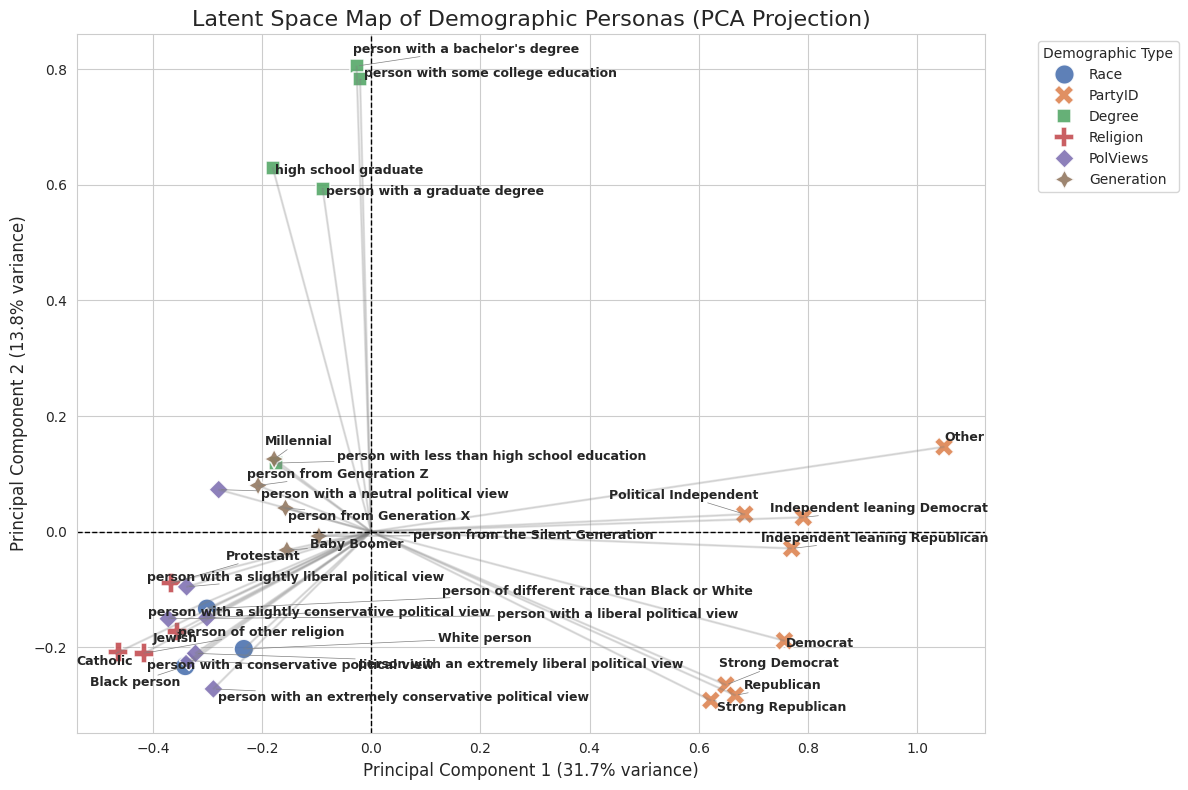

In [13]:
# Visualize the results
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# 1. PREPARE THE DATA (With Error Checking)

labels = []
vectors_list = []
categories = []

print("Checking for corrupted vectors...")

for key, data in demographic_vectors.items():
    # Convert to Numpy
    vec = data['vector'].cpu().numpy()

    # CHECK FOR NaNs or INFINITY
    if np.isnan(vec).any() or np.isinf(vec).any():
        print(f"WARNING: Skipping '{key}' - Vector contains NaNs (Magnitude was likely 0).")
        continue # Skip this vector, don't add to list

    # If valid, add to lists
    vectors_list.append(vec)
    labels.append(key)

    # Extract Category
    category = key.split('_')[0] if '_' in key else "Other"
    categories.append(category)

if len(vectors_list) == 0:
    raise ValueError("All vectors were NaN! Check your extraction code.")

# Convert to Matrix
X = np.array(vectors_list)
print(f"Successfully loaded {len(X)} valid vectors for plotting.")


# 2. RUN PCA (Dimensionality Reduction)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Calculate how much info is preserved
explained_variance = pca.explained_variance_ratio_
print(f"Variance Explained: PC1: {explained_variance[0]:.2%}, PC2: {explained_variance[1]:.2%}")
print(f"Total Information Preserved: {sum(explained_variance):.2%}")

# Create a DataFrame for easy plotting with Seaborn
df_plot = pd.DataFrame({
    'x': X_2d[:, 0],
    'y': X_2d[:, 1],
    'label': labels,
    'category': categories
})


# 3. GENERATE THE PLOT
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Draw the scatter plot
plot = sns.scatterplot(
    data=df_plot,
    x='x', y='y',
    hue='category',     # Color by Category (Party, Race, etc.)
    style='category',   # Different shapes for different categories
    s=200,              # Dot size
    palette='deep',
    alpha=0.9
)

# Draw arrows from origin (0,0) to points (Vectors are directions!)

for i in range(len(df_plot)):
    plt.arrow(
        0, 0,
        df_plot.x[i], df_plot.y[i],
        color='gray', alpha=0.2, width=0.002, head_width=0.0
    )

# Add Text Labels (with some offset to avoid overlapping dots)
from adjustText import adjust_text
texts = []
for i in range(len(df_plot)):
    # Clean up label for display (remove "Party_" prefix)
    display_text = df_plot.label[i].split('_')[-1]
    texts.append(plt.text(df_plot.x[i], df_plot.y[i], display_text, fontsize=9, weight='bold'))

try:
    from adjustText import adjust_text
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
except ImportError:
    pass

# Final Polish
plt.title("Latent Space Map of Demographic Personas (PCA Projection)", fontsize=16)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.1%} variance)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.1%} variance)", fontsize=12)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Demographic Type")
plt.tight_layout()

plt.show()

Centering vectors by category...


/tmp/ipython-input-34477491.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  centered_vectors = df_vec.groupby('category', group_keys=False).apply(center_vectors)


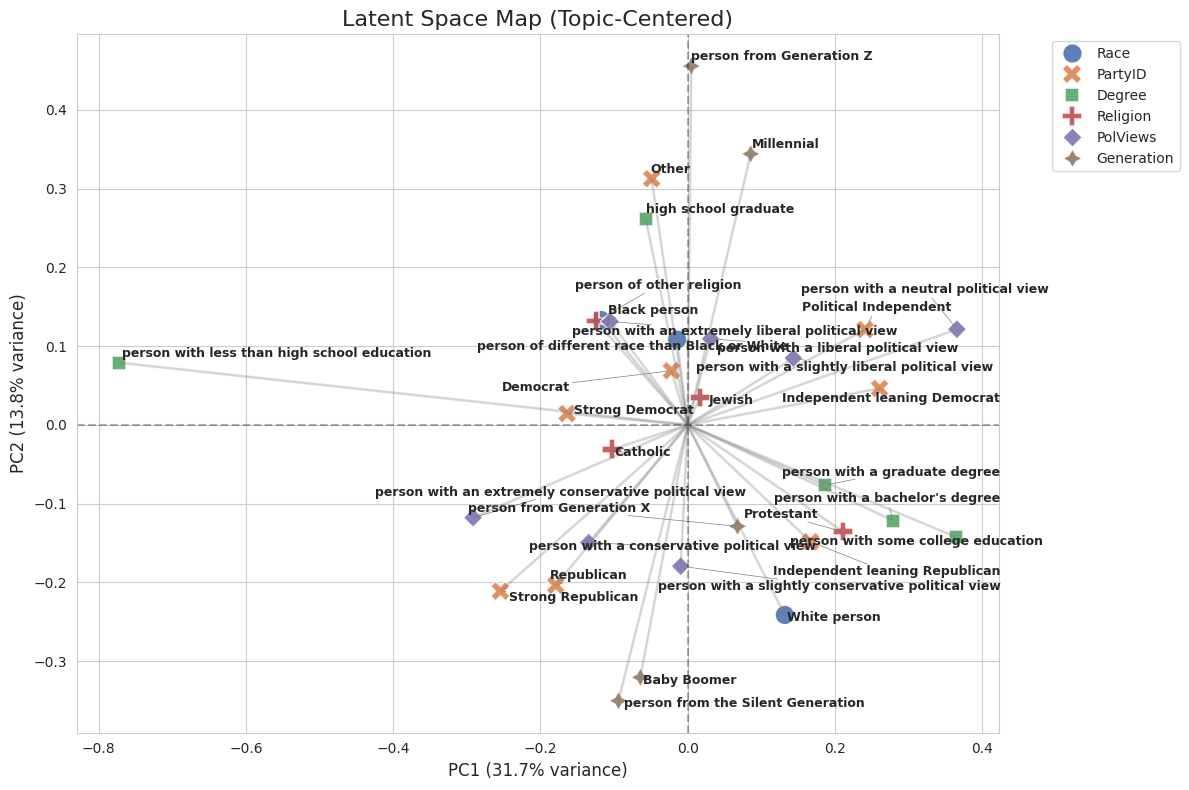

In [14]:
# 1. LOAD DATA INTO DATAFRAME
# (Assuming you already have 'vectors_list', 'labels', 'categories' from previous step)
df_vec = pd.DataFrame(vectors_list) # Columns 0 to 4095
df_vec['category'] = categories
df_vec['label'] = labels

# 2. PERFORM "CENTERING" (The Fix)
# For each category (e.g., "Party"), calculate the mean vector and subtract it
# from every member of that category.
print("Centering vectors by category...")

def center_vectors(group):
    # Select just the numeric vector columns
    vec_cols = group.loc[:, 0:4095]
    # Subtract the group mean
    return vec_cols - vec_cols.mean()

# Apply the centering
centered_vectors = df_vec.groupby('category', group_keys=False).apply(center_vectors)
X_centered = centered_vectors.values

# 3. RUN PCA ON CENTERED DATA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_centered)

# 4. PLOT
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create plot data
df_plot = pd.DataFrame({
    'x': X_2d[:, 0],
    'y': X_2d[:, 1],
    'category': df_vec['category'],
    'label': df_vec['label']
})

sns.scatterplot(
    data=df_plot,
    x='x', y='y',
    hue='category',
    style='category',
    s=200, alpha=0.9, palette='deep'
)

# Draw arrows from origin (0,0) to points (Vectors are directions!)

for i in range(len(df_plot)):
    plt.arrow(
        0, 0,
        df_plot.x[i], df_plot.y[i],
        color='gray', alpha=0.2, width=0.002, head_width=0.0
    )

# Add Text Labels (with some offset to avoid overlapping dots)
from adjustText import adjust_text
texts = []
for i in range(len(df_plot)):
    # Clean up label for display (remove "Party_" prefix)
    display_text = df_plot.label[i].split('_')[-1]
    texts.append(plt.text(df_plot.x[i], df_plot.y[i], display_text, fontsize=9, weight='bold'))

try:
    from adjustText import adjust_text
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
except ImportError:
    pass

plt.title("Latent Space Map (Topic-Centered)", fontsize=16)
plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)", fontsize=12)
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
# Extract pairs to test from gss_correlation_pairs.csv
gss_pairs = pd.read_csv("/content/drive/MyDrive/belief_and_llms_v0/gss_correlation_pairs.csv")
gss_pairs.head()

top_pos = gss_pairs[gss_pairs['Correlation'] > 0].head(10)
top_neg = gss_pairs[gss_pairs['Correlation'] < 0].head(10)
near_zero = gss_pairs[gss_pairs['Correlation'].abs() < 0.02].head(10)

pairs_to_test = []

for index, row in top_pos.iterrows():
    pairs_to_test.append((row['Var1'], row['Var2']))

for index, row in top_neg.iterrows():
    pairs_to_test.append((row['Var1'], row['Var2']))

for index, row in near_zero.iterrows():
    pairs_to_test.append((row['Var1'], row['Var2']))

pairs_to_test


[('polviews_Conservative', 'partyid_Strong republican'),
 ('partyid_Strong democrat', 'race_Black'),
 ('partyid_Strong democrat', 'polviews_Liberal'),
 ('polviews_Extremely conservative', 'partyid_Strong republican'),
 ('relig_Hinduism', 'race_Other'),
 ('relig_Protestant', 'race_Black'),
 ('race_Other', 'relig_Catholic'),
 ('polviews_Moderate, middle of the road',
  'partyid_Independent (neither, no response)'),
 ('race_White', 'partyid_Strong republican'),
 ('partyid_Not very strong republican', 'polviews_Slightly conservative'),
 ('relig_Protestant', 'race_Other'),
 ('partyid_Strong democrat', 'race_White'),
 ('polviews_Moderate, middle of the road', 'partyid_Strong republican'),
 ('relig_Catholic', 'race_Black'),
 ('partyid_Not very strong republican', 'race_Black'),
 ('partyid_Not very strong democrat', 'polviews_Conservative'),
 ('partyid_Strong republican', 'race_Black'),
 ('polviews_Conservative', 'partyid_Strong democrat'),
 ('degree_Less than high school', 'race_White'),
 ('p

In [28]:
import torch
import torch.nn.functional as F

# Manual mapping for labels from gss_correlation_pairs.csv to demographic_vectors keys
label_mapping = {
    'polviews_Conservative': 'PolViews_person with a conservative political view',
    'partyid_Strong republican': 'PartyID_Strong Republican',
    'partyid_Strong democrat': 'PartyID_Strong Democrat',
    'race_Black': 'Race_Black person',
    'relig_Hinduism': None, # No direct match, will skip
    'relig_Protestant': 'Religion_Protestant',
    'race_Other': 'Race_person of different race than Black or White', # Best guess
    'polviews_Moderate, middle of the road': 'PolViews_person with a neutral political view',
    'race_White': 'Race_White person',
    'partyid_Not very strong republican': 'PartyID_Republican', # Closest match
    'partyid_Independent, close to democrat': 'PartyID_Independent leaning Democrat',
    'relig_Catholic': 'Religion_Catholic',
    'partyid_Not very strong democrat': 'PartyID_Democrat', # Closest match
    'partyid_Independent, close to republican': 'PartyID_Independent leaning Republican',
    'polviews_Extremely conservative': 'PolViews_person with an extremely conservative political view',
    'degree_High school': 'Degree_high school graduate',
    'degree_Less than high school': 'Degree_person with less than high school education',
    'generation_Millennial': 'Generation_Millennial',
    'generation_Silent Generation': 'Generation_person from the Silent Generation',
    'sex_FEMALE': None, # Skipped in prior analysis due to 0 magnitude, no specific gender vector
    'sex_MALE': None,   # Skipped in prior analysis due to 0 magnitude, no specific gender vector
    'relig_Jewish': 'Religion_Jewish',
    'relig_Muslim/islam': 'Religion_person of other religion', # Best guess
    'polviews_Slightly conservative': 'PolViews_person with a slightly conservative political view',
    'polviews_Liberal': 'PolViews_person with a liberal political view',
    'polviews_Extremely liberal': 'PolViews_person with an extremely liberal political view',
    'polviews_Slightly liberal': 'PolViews_person with a slightly liberal political view',
    'partyid_Independent (neither, no response)': 'PartyID_Political Independent',
    'generation_Baby Boomer': 'Generation_Baby Boomer'
}

# 1. SETUP: Get the High-Dim Centered Vectors

def get_vec(gss_label):
    """Retrieves the 4096-d numpy vector for a specific label after mapping it.
    gss_label: The label from the gss_correlation_pairs.csv (e.g., 'polviews_Conservative').
    """
    # Map the GSS label to the format used in df_vec
    mapped_label = label_mapping.get(gss_label)

    if mapped_label is None:
        return None

    # Find the index of the mapped label in df_vec
    idx_row = df_vec[df_vec['label'] == mapped_label].index

    if len(idx_row) == 0:
        # Mapped label not found in df_vec (e.g., due to filtering or original data issues)
        return None

    # Get the actual index (assuming a unique match)
    index_in_df_vec = idx_row[0]

    # Retrieve the centered vector using the index from centered_vectors
    centered_vector_data = centered_vectors.loc[index_in_df_vec]

    return torch.tensor(centered_vector_data.values, dtype=torch.float32)


results = []

for label_a_gss, label_b_gss in pairs_to_test:
    vec_a = get_vec(label_a_gss)
    vec_b = get_vec(label_b_gss)

    if vec_a is not None and vec_b is not None:
        # Calculate Cosine Similarity
        # Range: -1 (Opposite) to +1 (Identical)
        sim = F.cosine_similarity(vec_a.unsqueeze(0), vec_b.unsqueeze(0)).item()

        # # Determine rough expectation (just for display)
        # hypo = "Unknown"
        # if "Black" in label_a and "Democrat" in label_b: hypo = "High +"
        # if "Black" in label_a and "Republican" in label_b: hypo = "High -"

        results.append({'Var1':f"{label_a_gss}", 'Var2':f"{label_b_gss}", 'llm_sim': sim})

--- LLM Latent Similarity vs GSS Expectations ---
Pair                                               | LLM Sim    | GSS Hypo  
---------------------------------------------------------------------------


In [29]:
results

[{'Var1': 'polviews_Conservative',
  'Var2': 'partyid_Strong republican',
  'llm_sim': 0.5970657467842102},
 {'Var1': 'partyid_Strong democrat',
  'Var2': 'race_Black',
  'llm_sim': 0.3077859878540039},
 {'Var1': 'partyid_Strong democrat',
  'Var2': 'polviews_Liberal',
  'llm_sim': 0.5398848056793213},
 {'Var1': 'polviews_Extremely conservative',
  'Var2': 'partyid_Strong republican',
  'llm_sim': 0.6206902265548706},
 {'Var1': 'relig_Protestant',
  'Var2': 'race_Black',
  'llm_sim': -0.2199651598930359},
 {'Var1': 'race_Other',
  'Var2': 'relig_Catholic',
  'llm_sim': -0.10385990887880325},
 {'Var1': 'polviews_Moderate, middle of the road',
  'Var2': 'partyid_Independent (neither, no response)',
  'llm_sim': 0.6326393485069275},
 {'Var1': 'race_White',
  'Var2': 'partyid_Strong republican',
  'llm_sim': 0.08097470551729202},
 {'Var1': 'partyid_Not very strong republican',
  'Var2': 'polviews_Slightly conservative',
  'llm_sim': 0.4453021287918091},
 {'Var1': 'relig_Protestant',
  'Var

In [30]:
# Convert results list to DataFrame
df_results = pd.DataFrame(results)

# Define the save path in Google Drive
csv_save_path = "/content/drive/MyDrive/belief_and_llms_v0/demo_vectors_similarity_results.csv"

# Save to CSV
df_results.to_csv(csv_save_path, index=False)
df_results.head()

,Var1,Var2,llm_sim
0,polviews_Conservative,partyid_Strong republican,0.597066
1,partyid_Strong democrat,race_Black,0.307786
2,partyid_Strong democrat,polviews_Liberal,0.539885
3,polviews_Extremely conservative,partyid_Strong republican,0.620690
4,relig_Protestant,race_Black,-0.219965
